# ***Advanced Classification Predict***

Daniel Komape
Ulanda wilcocks
Maphuti Rose Ntsewa
Aphiwe Madela
Lesego Phaahla
Kay Khoza
I am Praise


# **Predict Overview: 2022 Climate Change Belief Analysis**

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

With this context, EDSA is challenging you during the Classification Sprint with the task of creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.






# **Problem statement**




  Build a robust Machine Learning Model that will be able to predict a person’s belief in Climate Change based on their Tweet Data, allowing companies to gain access into customer sentiment.

---
The business problem we are pitching to solve involves a fictional line of clothing sourced from sustainable and/or recycled sources that Woolworths is considering investing in. This will likely require a significant amount of capital expenditure and risk, with the need for novel material sourcing and production techniques likely increasing costs further. We are offering a machine learning platform that can determine customer sentiment about climate change based on tweets, large numbers of users and/or customers who express their belief that climate change is real and caused by humans may be significantly more likely to pay attention to (and consider purchasing) this new line of clothing if it were launched.



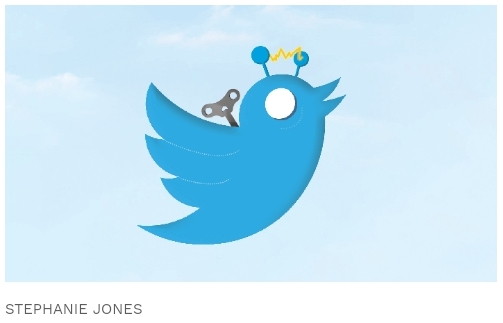

#  **Table of Contents**

1. Importing Packages

2. Loading Data

3. Exploratory Data Analysis (EDA)

4. Data Engineering

5. Modeling

6. Model Performance

7. Model Explanations

# 1. **Importing Packages**

Back to Table of Contents

In [1]:
# !pip install wordcloud

In [2]:
import comet_ml
from comet_ml import Experiment

ModuleNotFoundError: ignored

In [3]:
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from matplotlib.colors import ListedColormap
%matplotlib inline

# imports for Natural Language  Processing
import re
import os
import nltk
import time
import numpy as np
import pandas as pd
#import xgboost
from sklearn import metrics
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')

# Classification Models

from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB

# Performance Evaluation
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
#from scikitplot.metrics import plot_roc, plot_confusion_matrix
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

# Import library for train test split
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

#Resampling techniques -- not used here, but did try them.
from collections import Counter 
from sklearn.utils import resample
#from imblearn.over_sampling import SMOTE

# Ignore warnings
import warnings
warnings.simplefilter(action='ignore')

#spacy
#spacy.cli.download('en_core_web_sm')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 2. **Loading the Data**

## Back to Table of Contents

df_train: Dataframe that contains all the observations (tweets) used to train and test the model

df_test : Dataframe that contains all the observations (tweets) used to make Kaggle predictions

In [4]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test_with_no_labels.csv')

Initial Observations

Peak inside the training dataframe, both dataframes have the same number of columns and column types

In [5]:
df_train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


Variables definitions

sentiment: Sentiment of tweet
message: Tweet body
tweetid: Twitter unique id

Information about the dataframe. Both the sentiment and tweetid columns contain integer data, while the column with the feature we need to use to make predictions contains text data. This data is unstructured and not directly interpretable by the machine learning models we will be using, so it will have to undergo a considerable amount to pre-processing to convert into an appropriate form

Get the size of the dataframe. Three columns and 15819 rows, with each row corresponding to a single tweet/observation

In [6]:
df_train.shape

(15819, 3)

Get information about the null columns/rows in the dataframe. There are not any which means we do not need to consider any methods to deal with missing data. If there was missing data, particularly in the 'message' column, it is likely that the only solution would be to delete the offending observations since this is text data and traditional methods of data imputation would not work here.

In [7]:
df_train.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

Data Description

Has no null/missing values
The train and test datasets contains one categorical column called 'message'
The train dataset contains three columns
Some tweets contain twitter handles,numbers,hashtags and re-tweets.
New lines are represented by '\n' in the tweet string.

# 3. **Exploratory Data Analysis (EDA)**

In [8]:
df = df_train.copy()

Let us look at the distribution of tweets by their sentiment. This is clearly an imbalanced dataset. There are are over 6 times more tweets with a labeled 'pro'. as there are tweets labeled 'anti'. The second most common sentiment in the dataset is the 'News' category, with less than half the number of tweets as the 'pro' sentiment.

This has implications during model training, it is likely that the model will be significantly worse at correctly predicting the rarer sentiments.

In [9]:
sent_counts = df["sentiment"].value_counts()
sent_counts.name = "Count"
percs = df["sentiment"].value_counts(normalize=True) #turns out this normalize parameter converts to %
percs.name = "Percentage"

pd.concat([sent_counts, percs], axis=1)

,Count,Percentage
1,8530,0.539225
2,3640,0.230103
0,2353,0.148745
-1,1296,0.081927


Text(0.5, 1.0, 'Tweet sentiment distribution')

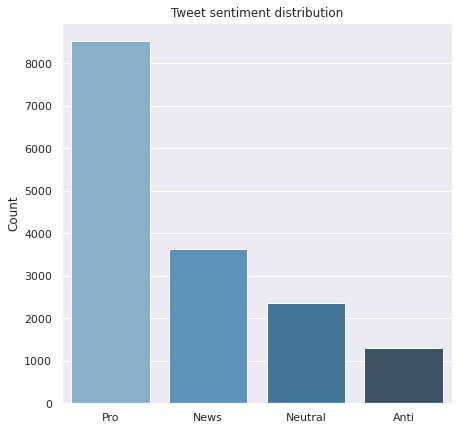

In [10]:
sentiment_distribution = pd.DataFrame(list(df['sentiment'].value_counts()),
                          index=['Pro', 'News', 'Neutral', 'Anti'],
                          columns=['Count'])
sns.set()
plt.figure(figsize=(7, 7))
sns.barplot(x=sentiment_distribution.index, y=sentiment_distribution.Count, 
           palette="Blues_d")
plt.title('Tweet sentiment distribution')

Let us look at the number of words in tweets

Create a new dataframe

In [11]:
tweet_df = df[['message','sentiment']]

To prep for EDA, we should do some preliminary text cleaning. Remove stopwords, punctuation etc. This isnt quite the same as what we will do for actual data pre-processing prior to model training

In [12]:
def remove_stop_words(tweet):
    words = tweet.split()
    l =  [t for t in words if t not in stopwords.words('english')]
    return ' '.join(l)

In [13]:
tweet_df['message'] = tweet_df['message'].str.lower()

In [14]:
puncs = "!\"$%&'()*+,-./:;<=>?[\]^_`{|}~"
def remove_punctuation(post):
    return ''.join([l for l in post if l not in puncs])

In [15]:
%%time
tweet_df['message'] = tweet_df['message'].apply(remove_punctuation)

CPU times: user 202 ms, sys: 3.93 ms, total: 206 ms
Wall time: 205 ms


In [16]:
%%time
tweet_df['message'] = tweet_df['message'].apply(remove_stop_words)

CPU times: user 26.7 s, sys: 2.97 s, total: 29.7 s
Wall time: 29.8 s


In [17]:
tweet_df.head()

,message,sentiment
0,polyscimajor epa chief doesnt think carbon dio...,1
1,like lack evidence anthropogenic global warming,1
2,rt @rawstory researchers say three years act c...,2
3,#todayinmaker# wired 2016 pivotal year war cli...,1
4,rt @soynoviodetodas 2016 racist sexist climate...,1


Create classes of sentiments

In [18]:
news_tweets = ' '.join([text for text in tweet_df['message']
                        [tweet_df['sentiment'] == 2]])
pro_tweets = ' '.join([text for text in tweet_df['message']
                       [tweet_df['sentiment'] == 1]])
neutral_tweets = ' '.join([text for text in tweet_df['message']
                           [tweet_df['sentiment'] == 0]])
anti_tweets = ' '.join([text for text in tweet_df['message']
                        [tweet_df['sentiment'] == -1]])

Visualise classes of sentiments

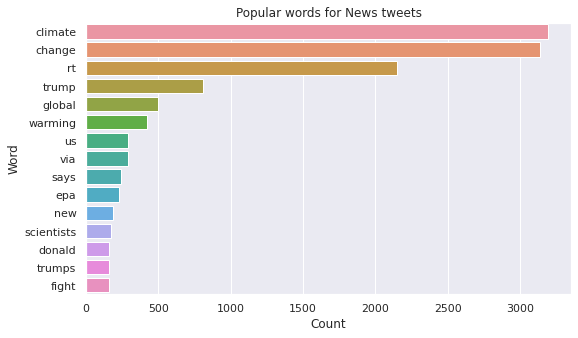

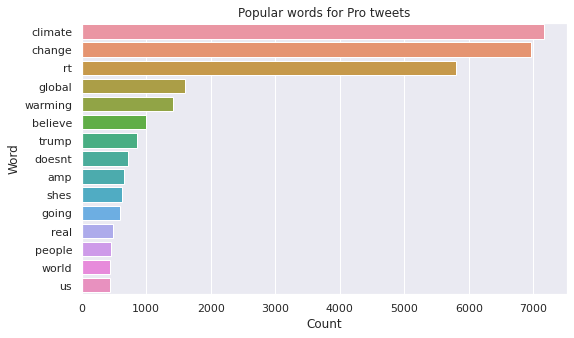

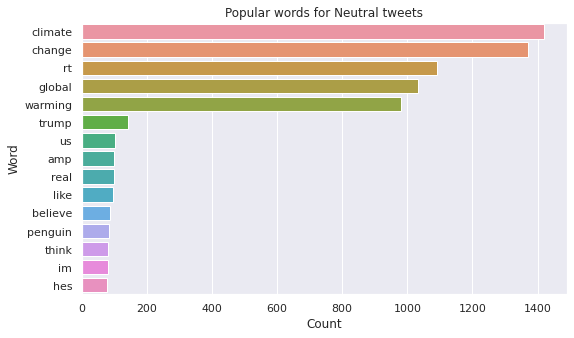

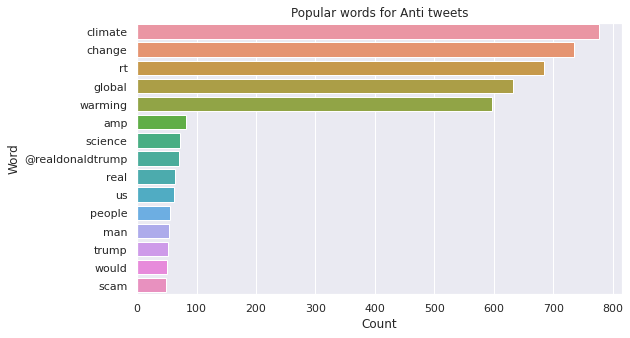

In [19]:
full_title = ['Popular words for News tweets',
              'Popular words for Pro tweets',
              'Popular words for Neutral tweets',
              'Popular words for Anti tweets']

tweet_list = [news_tweets, pro_tweets,
              neutral_tweets, anti_tweets]

plt.rcParams['figure.figsize'] = [40, 5]

for i, sent in enumerate(tweet_list):
    plt.subplot(1, 4, i + 1)
    freq_dist = nltk.FreqDist(sent.split(' '))
    df = pd.DataFrame({'Word': list(freq_dist.keys()),
                      'Count' : list(freq_dist.values())})

    df = df.nlargest(columns='Count', n=15)

    ax = sns.barplot(data=df, y='Word', x='Count')
    plt.title(full_title[i])
    plt.show()

Create wordclouds

In [20]:
conda install -c conda-forge wordcloud

SyntaxError: ignored

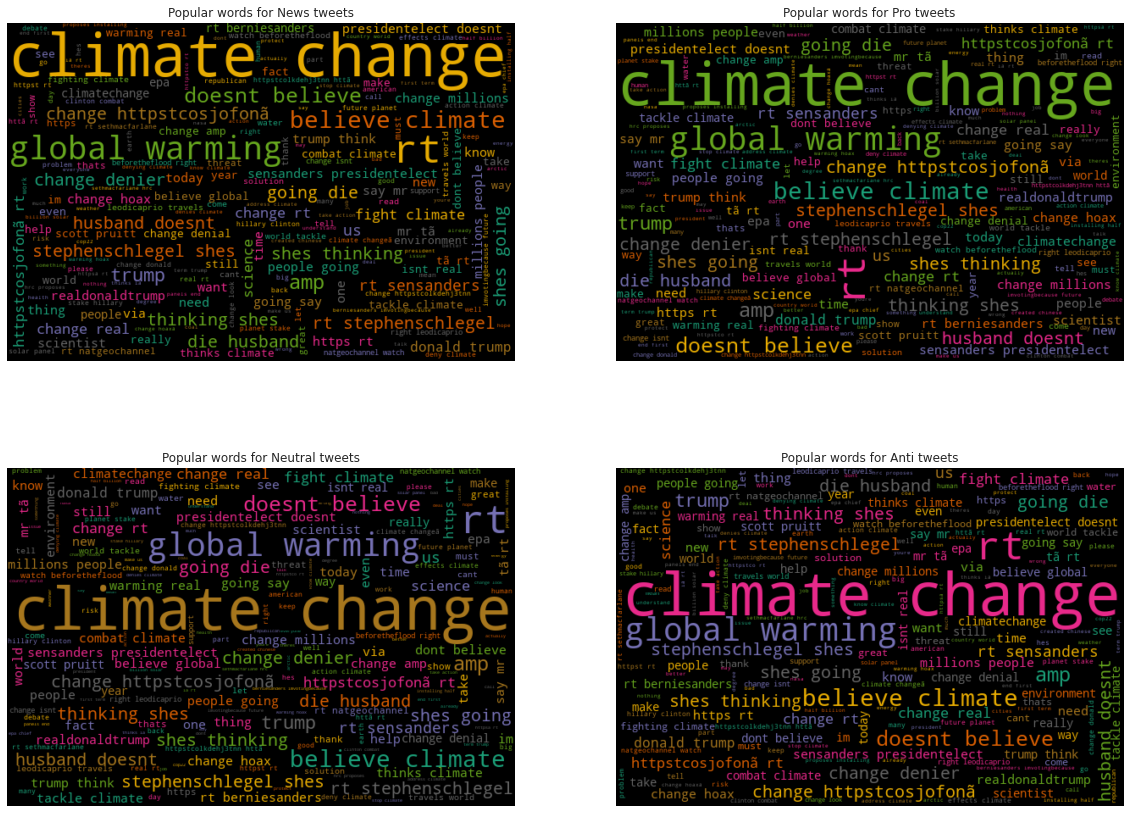

In [21]:
wc = WordCloud(width=600, height=400, 
               background_color='black', colormap='Dark2',
               max_font_size=150, random_state=42)

plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots 
for i in range(0, len(tweet_list)):
    wc.generate(tweet_list[1])
    
    plt.subplot(2, 2, i + 1)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(full_title[i])
    
plt.show()

We created a wordcloud to visualize the most tweeted keywords in each sentiment class. We see that a lot of unimportant words and stopwords are still visible. We also see that the keywords "climate change, global warming and belief" are common in all sentiment classes. 'https' words are frequent in all sentiment classes to show that links are shared in tweets.

 Extracting hashtags

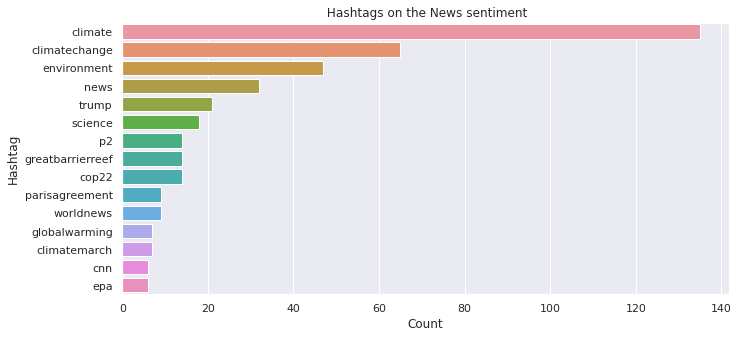

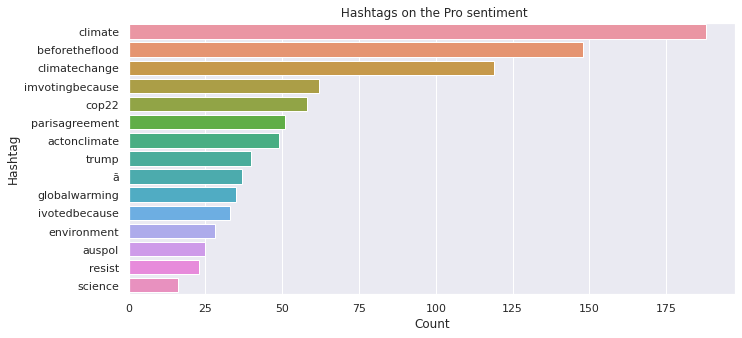

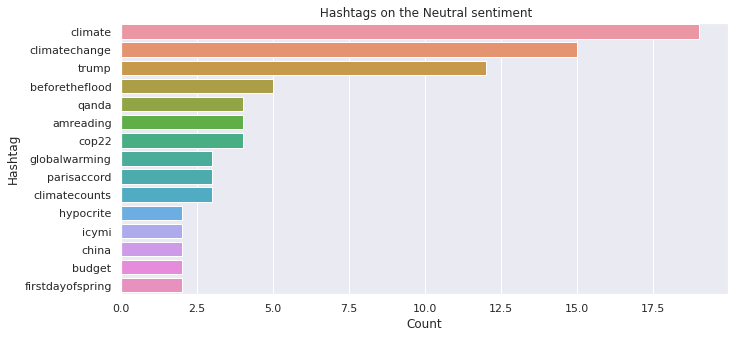

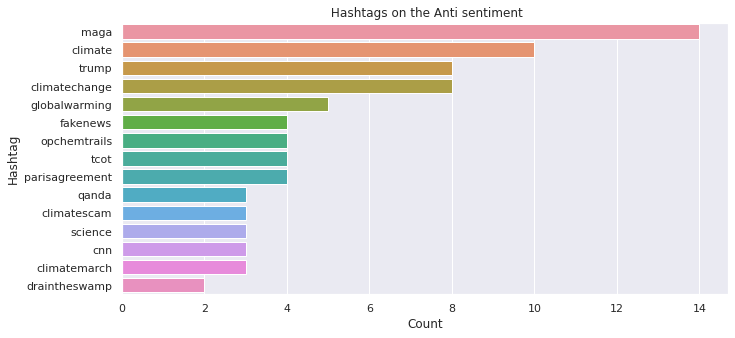

In [22]:
def extract_hashtags(x):
    hashtags = []
    for i in x:
        hash = re.findall(r'#(\w+)', i)
        hashtags.append(hash)
        
    return hashtags

# Extracting hashtags from tweets
news_hashtags = extract_hashtags(tweet_df['message']
                              [tweet_df['sentiment'] == 2])
pro_hashtags = extract_hashtags(tweet_df['message']
                          [tweet_df['sentiment'] == 1])
neutral_hashtags = extract_hashtags(tweet_df['message']
                              [tweet_df['sentiment'] == 0])
anti_hashtags = extract_hashtags(tweet_df['message']
                          [tweet_df['sentiment'] == -1])

# hashtag list
hashtags = [sum(news_hashtags, []), sum(pro_hashtags, []),
            sum(neutral_hashtags, []),sum(anti_hashtags, [])]

# Visualising the Hashtags
ft = [' Hashtags on the News sentiment',
              ' Hashtags on the Pro sentiment',
              ' Hashtags on the Neutral sentiment',
              ' Hashtags on the Anti sentiment']

plt.rcParams['figure.figsize'] = [50, 5]

for i, sent in enumerate(hashtags):
    plt.subplot(1, 4, i + 1)
    freq_dist = nltk.FreqDist(sent)
    df = pd.DataFrame({'Hashtag': list(freq_dist.keys()),
                      'Count' : list(freq_dist.values())})

    df = df.nlargest(columns='Count', n=15)
    ax = sns.barplot(data=df, y='Hashtag', x='Count')
    plt.title(ft[i])
    plt.show()

 Extracting twitter handles

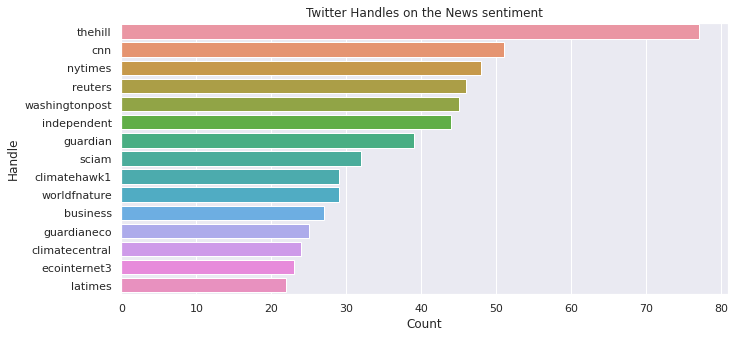

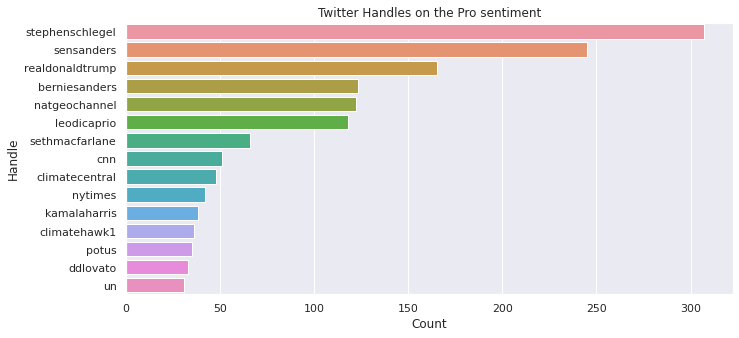

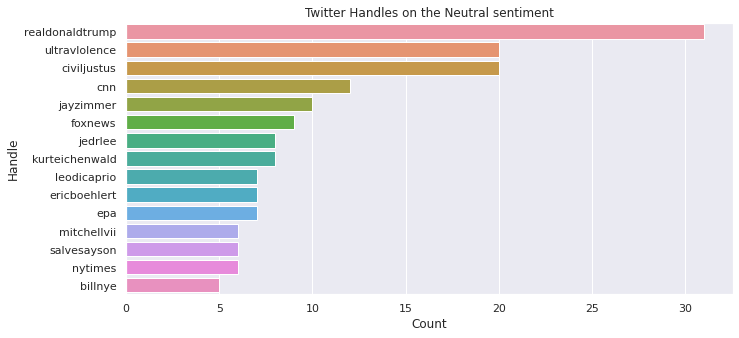

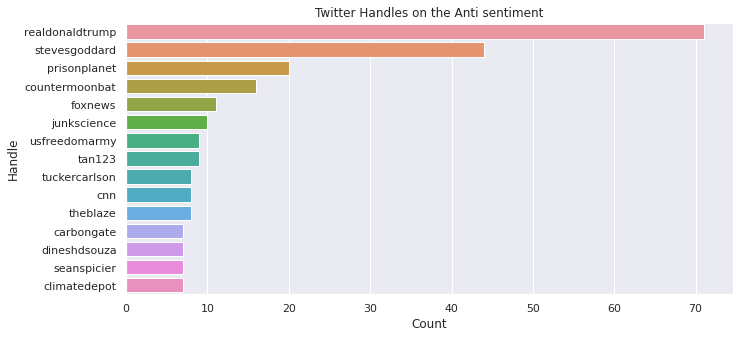

In [23]:
def extract_handles(x):
    handles = []
    for i in x:
        h = re.findall(r'@(\w+)', i)
        handles.append(h)
        
    return handles

news_handles = extract_handles(tweet_df['message']
                              [tweet_df['sentiment'] == 2])
pro_handles = extract_handles(tweet_df['message']
                          [tweet_df['sentiment'] == 1])
neutral_handles = extract_handles(tweet_df['message']
                              [tweet_df['sentiment'] == 0])
anti_handles = extract_handles(tweet_df['message']
                          [tweet_df['sentiment'] == -1])

# handle lists 
handles = [sum(news_handles, []), sum(pro_handles, []), sum(neutral_handles, []),
           sum(anti_handles, [])]

# Visualising the Handles
full_title = ['Twitter Handles on the News sentiment',
              'Twitter Handles on the Pro sentiment',
              'Twitter Handles on the Neutral sentiment',
              'Twitter Handles on the Anti sentiment']

plt.rcParams['figure.figsize'] = [50, 5]

for i, sent in enumerate(handles):
    plt.subplot(1, 4, i + 1)
    freq_dist = nltk.FreqDist(sent)
    df = pd.DataFrame({'Handle': list(freq_dist.keys()),
                      'Count' : list(freq_dist.values())})

    df = df.nlargest(columns='Count', n=15)

    ax = sns.barplot(data=df, y='Handle', x='Count')
    plt.title(full_title[i])
    plt.show()

The most popular handles are that of media networks, journalists and politicians. This is expected considering the topic of the dataset. News articles are often what trigger discussions online about climate change. Some of the handles unique to the anti sentiment are FoxNews, TuckerCarlson and DineshDSouza. Fox News is a popular right-wing cable news network in the US, Tucker Carlson is a news anchor at Fox News and DineshDSouza is an american right-wing 'commentator'. In the Neutral sentiment, ULTRAVIOLENCE likely referes to Lana Del Rey's popular album of the same name that came out shortly before this dataset was assmbled.

Now lets see how many tweets contain URLs, and group this by sentiment so we can determine whether tweets of a specific sentiment contain more URLs than others

Now lets see how many tweets contain URLs, and group this by sentiment so we can determine whether tweets of a specific sentiment contain more URLs than others

In [24]:
def find_url(tweet):
    '''This function uses regex to look for a URL in a tweet, if it finds one it returns the URL
    Otherwise it returns NO URL FOUND'''
    url_pattern = 'https://(t.co|bit.ly)/[a-zA-Z0-9]*' #All twitter links are shortened URLs
    url_results = re.search(url_pattern, tweet, re.IGNORECASE)
    if not url_results is None:
        url = url_results.group()
        return url
    else:
        return "NO URL FOUND"

In [29]:
link_percs = {}

def count_links(tweet):
    '''This function checks if there is a link in the tweet using the function in the cell above'''
    check = find_url(tweet)
    #print(tweet)
    if check == "NO URL FOUND":
        return 0
    else:
        return 1 

by_sentiment = tweet_df.groupby("sentiment") #Group data by sentiment since we are counting hashtags by sentiment
for sentiment, group in by_sentiment: #group contains all the tweets for each sentiment
    counts = group["message"].apply(count_links)
    summed = sum(counts)
    sent_count = len(group)
    link_percs[str(sentiment)] = round(summed/sent_count*100,2)
linkdf= pd.DataFrame.from_dict(link_percs, orient='index')
linkdf.columns = ['percentage']
linkdf.index.name = 'sentiment'
linkdf.index =['Anti', 'Neutral', 'Pro', 'News']
linkdf.index.name = 'sentiment'
linkdf.head()

,percentage
sentiment,
Anti,0.0
Neutral,0.0
Pro,0.0
News,0.0


Text(0.5, 1.0, 'Portion of tweets with a URL in them by sentiment')

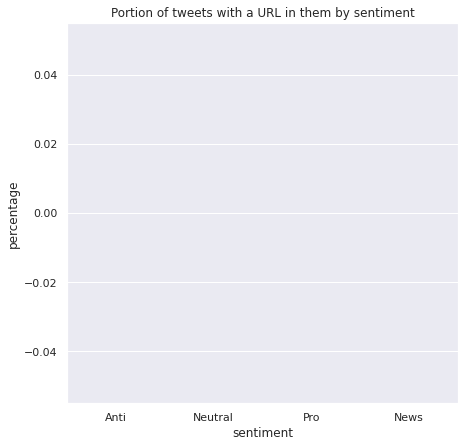

In [30]:
plt.figure(figsize=(7, 7))
sns.barplot(data=linkdf, 
           palette="Blues_d", y='percentage', x=linkdf.index)
plt.title('Portion of tweets with a URL in them by sentiment')

# 4.**Data Engineering**